# Model Metrics

* **Last Modified**: 07-04-2021
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

This notebook shows how to compute metrics for a trained model on the *WorldFloods* test dataset. The notebook is divided in 4 steps:

1. Load the config file of the experiment.
1. Create a dataloader for the test dataset.
1. Create the segmentation model and load their weights
1. Run inference on all images in the dataset and compute metrics

In [2]:
# !pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [1]:
import sys, os
from pathlib import Path

# %load_ext autoreload
# %autoreload 2

## Step 1: Get config

In [2]:
from ml4floods.models.config_setup import get_default_config
from imp import reload

experiment_name = "WFV1_unet"
# checkpoint_name = "epoch=24-step=153649.ckpt"

# experiment_name = "WFV1_scnn20"
# checkpoint_name = "epoch=5-step=24581.ckpt"

# V2 models
# experiment_name = "WF2_unet"
# checkpoint_name = "epoch=5-step=24215.ckpt"

config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
# config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

## Step 2: Load dataloader

In [3]:
from ml4floods.models import dataset_setup

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/worldfloods/v1" # local folder to download the data
config.data_params.bucket_id = "ml4cc_data_lake" 
config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" 
config.data_params.test_transformation.normalize = False

config.data_params["download"] = {"train": False, "val": False, "test": True} # download only test data

if "filter_windows" in config["data_params"]:
    del config["data_params"]["filter_windows"]


In [4]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
Skip download train
Skip download val
train 2424  tiles
val 1284  tiles
test 11  tiles


In [5]:
dl = data_module.test_dataloader()
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [6]:
from ml4floods.models.architectures import ndwi

def prediction_function(x):
    return ndwi.extract_mndwi(x)


In [15]:
cosa = iter(dl)
batch = next(cosa)
x = batch["image"]
gt = batch["gt"]

In [23]:
gt = batch["mask"]
gt.shape


torch.Size([1, 1, 2643, 2170])

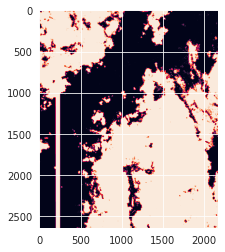

In [25]:
gt2 = torch.clone(gt[:, 0])
# Save invalids to discount
invalids = gt2 == 0

# Do not consider cloud pixels for metrics
invalids |= (gt2 == 3)
    
plt.imshow(invalids.numpy()[0],vmin=0,vmax=1)

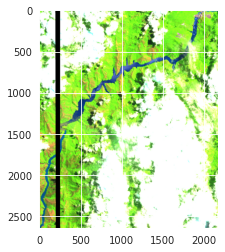

In [16]:
from ml4floods.visualization import plot_utils

plot_utils.plot_s2_swirnirred_image(x[0])

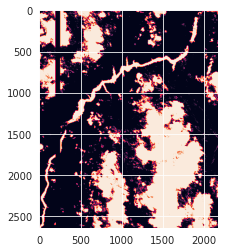

In [19]:
import matplotlib.pyplot as plt

mndwi = prediction_function(x)

plt.imshow(mndwi.numpy()[0,0] > 0,vmin=0,vmax=1)

In [28]:
mets["confusions"][0]/np.sum(mets["confusions"][0])

array([[0.87236094, 0.01157885],
       [0.05410995, 0.06195026]])

## Step 4: Run inference on all the images in the test dataset

100%|██████████| 11/11 [03:23<00:00, 18.48s/it]


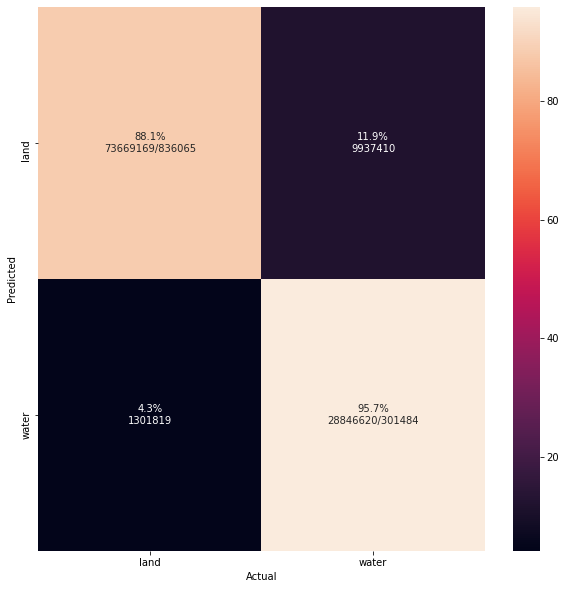

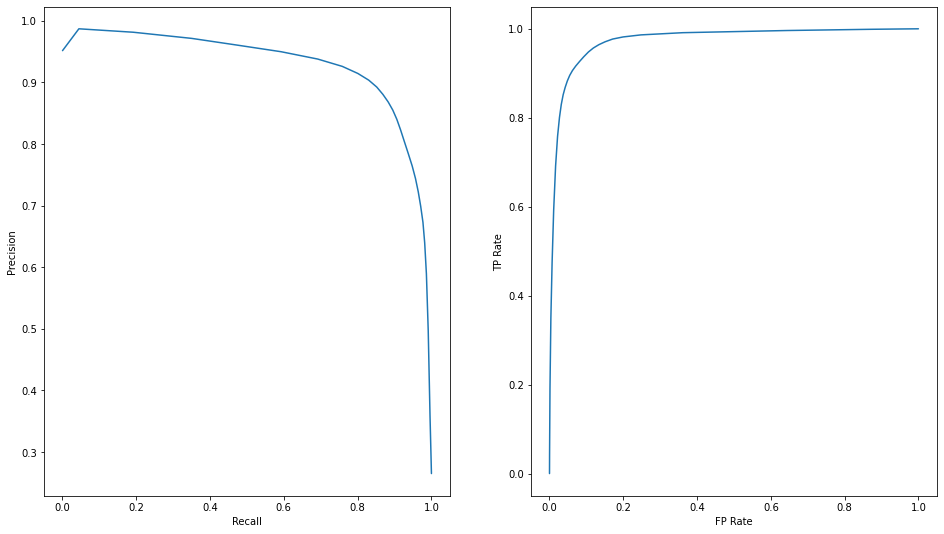

Per Class IOU {
    "land": 0.8676311264287646,
    "water": 0.7196210313520294
}


In [7]:
import torch
import numpy as np
import pandas as pd
from ml4floods.models.utils import metrics
from ml4floods.models.architectures import ndwi

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = np.arange(-1, 1, .05)

mets = metrics.compute_metrics(
    dl,
    prediction_function, 
    thresholds_water=thresholds_water, 
    threshold=0,
    mask_clouds=True,
    plot=False)

label_names = ["land", "water"]
metrics.plot_metrics(mets, label_names)

## Bonus: Compute the metrics for each flood in the test dataset

In [40]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in label_names]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in label_names]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code["code"] = join_data_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 88.7614994022509, 'Recall_water': 90.19063587539165, 'IoU_land': 87.46885085385198, 'IoU_water': 60.38041042486155}


,Recall_land,Recall_water,IoU_land,IoU_water
code,,,,
EMSR286 (Colombia),94.461746,84.260520,93.290758,49.726954
EMSR333 (Italy),89.492676,89.143209,88.938695,31.483486
EMSR342 (Australia),68.382185,97.702236,66.912932,73.412578
EMSR347 (Malawi),97.395226,86.231255,96.170393,67.284190
EMSR284 (Finland),94.075665,93.615959,92.031476,79.994845


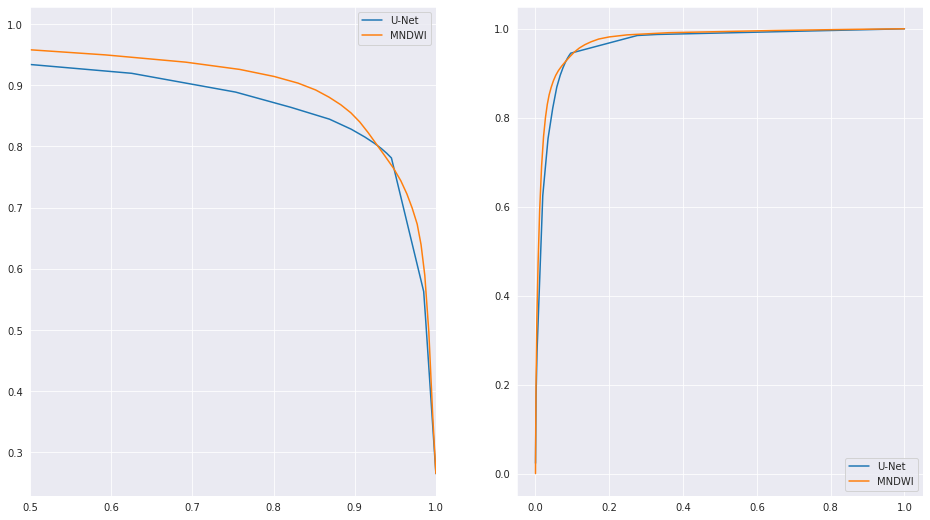

In [39]:
import json
import compute_prcurve
import matplotlib.pyplot as plt
import seaborn as sns


with open("confs_unet.json", "r") as fh:
    mets_unet = json.load(fh)

plot_df_unet = compute_prcurve.pr_df(mets_unet["confusions_thresholded"])
plot_df_mndwi = compute_prcurve.pr_df(mets["confusions_thresholded"])


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set_style('darkgrid')

ax[0].plot(plot_df_unet["Recall"], 
           plot_df_unet["Precision"],label="U-Net")

ax[0].plot(plot_df_mndwi["Recall"], 
           plot_df_mndwi["Precision"],label="MNDWI")

ax[1].plot(plot_df_unet["FP Rate"], 
           plot_df_unet["TP Rate"],label="U-Net")

ax[1].plot(plot_df_mndwi["FP Rate"], 
           plot_df_mndwi["TP Rate"],label="MNDWI")

ax[0].set_xlim(.5,1)
ax[0].legend()
ax[1].legend()

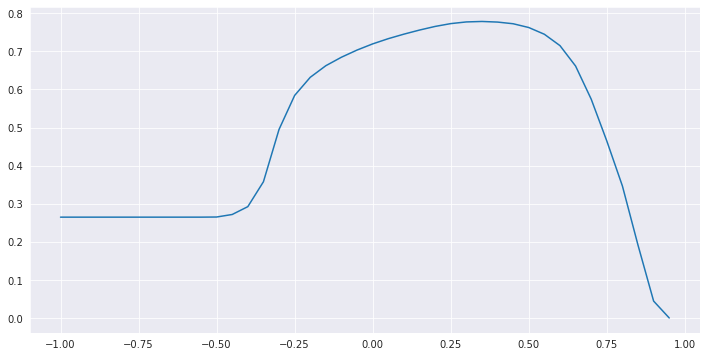

In [53]:
iou_water = [metrics.calculate_iou(c,labels=label_names)['water'] for c in mets["confusions_thresholded"]]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(mets["thresholds"], iou_water)

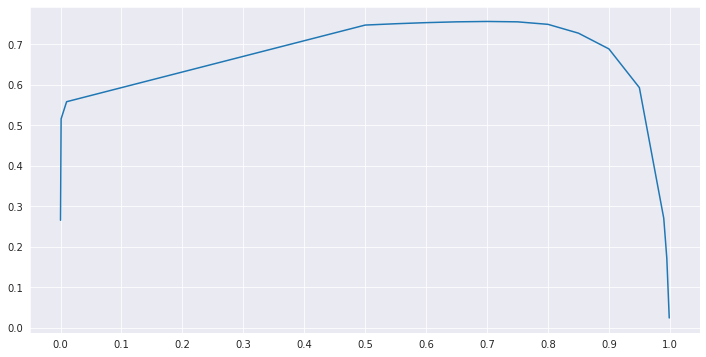

In [52]:
iou_water_unet = [metrics.calculate_iou(c,labels=label_names)['water'] for c in mets_unet["confusions_thresholded"]]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(mets_unet["thresholds"], iou_water_unet)
_ = ax.set_xticks(np.arange(0,1.01,.1))